# Linear classification

Topics:
1. Linear classification
2. The Sigmoid function and the Softmax
3. Stochastic Gradient Descent solution
4. Evaluation
5. Implementations
6. Exercise

In [28]:
# imports

import os, codecs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

* **Regression**: predict real/continuous values given inputs (e.g., a salary of 2.15 ducats a year).
* **Classification**: predict categorical values given inputs (e.g., there is a female guarantor in the contract or not).

## Sigmoid function

This is used for binary classification, the Softmax generalizes it to multiple classes.

The Sigmoid function takes a line and "squeezes" it into a shape more suitable for binary decisions.

Model:

$\hat{y} = \frac{1}{1 + e^{-\big(b + \sum_{j=1}^{d}w_j x_j \big)}}$

In [3]:
# shape of a sigmoid function
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

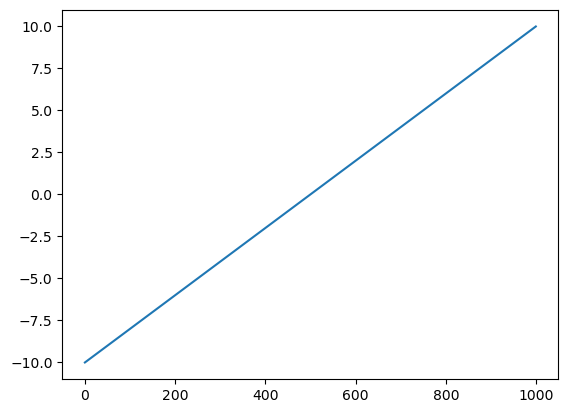

In [4]:
plt.plot(np.linspace(-10,10,1000))

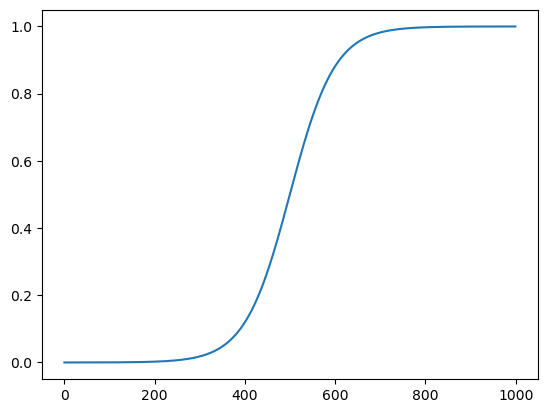

In [5]:
plt.plot([sigmoid(x) for x in np.linspace(-10,10,1000)])

## Softmax

Model, in matrix form (4.1.5):

$O = XW + b$

$\hat{Y} = softmax(O)$

Where:

$softmax(o) = \frac{exp(o)}{\sum_{j=1}^q exp(o_j)}$

We call $\textbf{o}$ the logits, and $q$ is the number of classes. The loss function we use is the well-known cross-entropy loss (4.1.8):

$l(y,\hat{y}) = - \sum_{j=1}^q y_j log(\hat{y}_j)$

The derivative of the loss, w.r.t. any logit $o_i$ is:

$\partial_{o_i} l(y,\hat{y}) = softmax(o_i) - y_i$

And the derivative w.r.t. weights is, by chain rule:

$\partial_{W} L(Y,\hat{Y}) = X^T * (softmax(O) - Y)$

In [6]:
# Mock training data
X_train = np.array([[0.1, 0.5, 0.4],
                    [0.3, 0.2, 0.5],
                    [0.6, 0.1, 0.3],
                    [0.8, 0.1, 0.1]])

# Note that we use one-hot encoding
y_train = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1],
                    [1, 0, 0]])

In [7]:
def softmax(logits):
    # We make all logits below zero to avoid overflow errors, see 4.5.2
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    # Assuming y_true is one-hot encoded
    # We add a little number to the predictions to avoid underflow errors, see 4.5.2
    m = y_true.shape[0]
    return (1/m) * -np.sum(y_true * np.log(y_pred + 1e-12))

def compute_gradients(X, y_true, y_pred):
    # Compute the gradient of the cross-entropy loss with respect to the logits
    m = y_true.shape[0]
    grad = (1/m) * np.matmul(X.T,(y_pred - y_true))
    return grad

def update_weights(weights, gradients, learning_rate):
    return weights - learning_rate * gradients

In [8]:
# Randomly initialize weights
np.random.seed(42)
weights = np.random.rand(X_train.shape[1], y_train.shape[1])

# Training hyperparameters
learning_rate = 0.1
epochs = 10

for epoch in range(epochs):
    logits = np.matmul(X_train, weights)
    y_pred = softmax(logits)
    
    loss = cross_entropy_loss(y_train, y_pred)
    gradients = compute_gradients(X_train, y_train, y_pred)
    weights = update_weights(weights, gradients, learning_rate)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Display final weights
print("Final weights:", weights)

Epoch 0, Loss: 1.1300
Final weights: [[0.48109521 0.84544249 0.73071067]
 [0.68243812 0.12045872 0.10777481]
 [0.09265511 0.86389028 0.56882938]]


In [9]:
# Prediction

X_test = np.array([[0.3, 0.3, 0.4],
                    [0.9, 12, 0.8]])
y_pred = softmax(np.matmul(X_test,weights))

In [10]:
y_pred

array([[0.29582149, 0.37954024, 0.32463827],
       [0.99513864, 0.0030163 , 0.00184507]])

In [11]:
np.max(y_pred,1)

array([0.37954024, 0.99513864])

In [12]:
np.argmax(y_pred,1)

array([1, 0])

In [13]:
# Let's do another example with more data

from sklearn.datasets import make_classification # a simple way to create classification data
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)

In [14]:
X.shape

(1000, 2)

In [15]:
y.shape

(1000,)

In [16]:
np.unique(y)

array([0, 1])

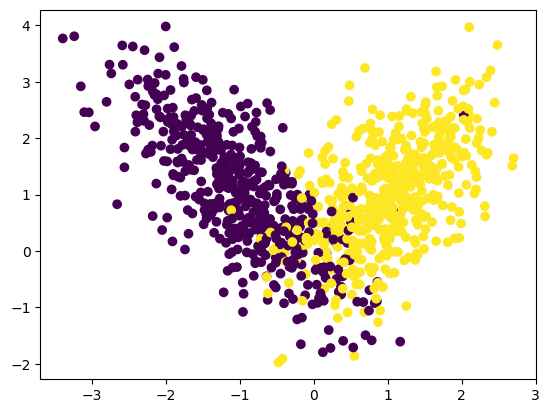

In [17]:
plt.scatter(X[:,0], X[:,1], c=y)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Make y to one hot encoding
y_one_hot = np.zeros((y_train.size, y_train.max() + 1))
y_one_hot[np.arange(y_train.size), y_train] = 1
y_one_hot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [20]:
# Randomly initialize weights
np.random.seed(42)
weights = np.random.rand(X_train.shape[1], y_one_hot.shape[1])

# Training hyperparameters
learning_rate = 0.01
epochs = 1000

for epoch in range(epochs):
    logits = np.dot(X_train, weights)
    y_pred = softmax(logits)
    
    loss = cross_entropy_loss(y_one_hot, y_pred)
    gradients = compute_gradients(X_train, y_one_hot, y_pred)
    weights = update_weights(weights, gradients, learning_rate)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Display final weights
print("Final weights:", weights)

Epoch 0, Loss: 0.4707
Epoch 100, Loss: 0.3609
Epoch 200, Loss: 0.3141
Epoch 300, Loss: 0.2886
Epoch 400, Loss: 0.2728
Epoch 500, Loss: 0.2620
Epoch 600, Loss: 0.2544
Epoch 700, Loss: 0.2486
Epoch 800, Loss: 0.2442
Epoch 900, Loss: 0.2407
Final weights: [[-0.51392176  1.83917619]
 [ 0.58507819  0.74557424]]


## Evaluation

We can use the loss, but this is not very informative. More often, in classification, we use the **accuracy**: the fraction of correctly labelled datapoints in the test set.

In [21]:
y_pred = softmax(np.matmul(X_test,weights))
y_pred = np.ravel(np.argmax(y_pred,1))

In [22]:
y_pred

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0])

In [23]:
y_test

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0])

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.92

## Implementations

Ad usual **sklearn** is a great starting point. See the [LogisticRegression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (despite the name, it does classification..).

In [25]:
# Let's create some data as before

from sklearn.datasets import make_classification # a simple way to create classification data
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)

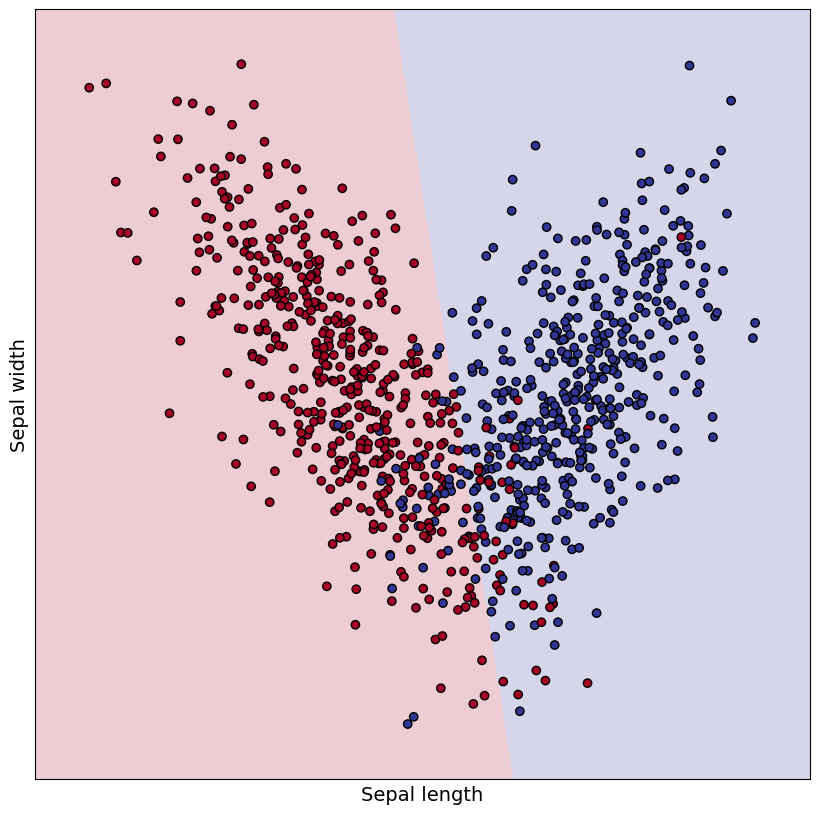

In [26]:
# From: https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py
# Let's train a model, make predictions and show the decision boundary

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.2)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)
plt.xlabel('Sepal length', fontsize=14)
plt.ylabel('Sepal width', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

### Questions

* Extend to multiple classes, and investigate how LogisticRegression allows you to integrate regularization.
* Implement the same classification task using [an MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron).

## Exercise: Tesla vs SpaceX tweets

In [27]:
import nltk
import string
import sklearn

In [ ]:
# load the dataset

root_folder = "data/musk_tweets"
df_elon = pd.read_csv(codecs.open(os.path.join(root_folder,"df_elon.csv"), encoding="utf8"), sep=",")

In [ ]:
df_elon.head(5)

In [ ]:
# Filter to just Tesla or SpaceX

def classify_t_or_s(tweet):
    
    if type(tweet) == str and "@SpaceX" in tweet:
        return 1
    elif type(tweet) == str and "@TeslaMotors" in tweet:
        return 0
    return -1

def remove_t_or_s(tweet):
    
    if type(tweet) == str:
        removed = tweet.replace("@SpaceX","")
        removed = removed.replace("@TeslaMotors","")
        return removed
    return ""

In [ ]:
# Create classes and remove the discriminant token!
df_elon["class"] = df_elon["clean_text"].apply(classify_t_or_s)
df_elon["clean_text_rm"] = df_elon["clean_text"].apply(remove_t_or_s)

In [ ]:
df_elon[df_elon["class"] == 1].head(5)

In [ ]:
df_reduced = df_elon[df_elon["class"] != -1]
df_reduced.shape

In [ ]:
# We tokenize the dataset using NLTK, and create the TF-IDF representation using Sklearn

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(tokenizer=tknzr.tokenize)
X = count_vect.fit_transform(df_reduced.clean_text_rm)
X.shape

In [ ]:
y = df_reduced["class"].values

In [ ]:
# Create an instance of Logistic Regression Classifier and fit the data.
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

logreg.fit(X, y)

In [ ]:
# Try it out

test_tweet1 = "Let's all go to Mars and colonize!"
test_tweet2 = "Let's all go on with an electric car with auto pilot"
x = count_vect.transform([test_tweet1])
print(logreg.predict(x)[0])
print(logreg.predict_proba(x)[0])

In [ ]:
x

*But, does it actually work?*

### Evaluation

#### Exploratory vs confirmatory modelling

"Traditionally, the focus of modelling is on *inference, or for confirming that an hypothesis is "true"*. Doing this correctly is not complicated, but it is hard. There is a pair of ideas that you must understand in order to do inference correctly:

* Each observation can either be used for exploration or confirmation, not both.

* You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.

This is necessary because to confirm a hypothesis you must use data independent of the data that you used to generate the hypothesis. Otherwise you will be over optimistic. There is absolutely nothing wrong with exploration, but you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.

If you are serious about doing a confirmatory analysis, one approach is to split your data into three pieces before you begin the analysis:

* 60% of your data goes into a **training** (or exploration) set. You’re allowed to do anything you like with this data: visualise it and fit tons of models to it.

* 20% goes into a **validation** set. You can use this data to compare models or visualisations by hand, but you’re not allowed to use it as part of an automated process.

* 20% is held back for a **test** set. You can only use this data ONCE, to test your final model.

This partitioning allows you to explore the training data, occasionally generating candidate hypotheses that you check with the query set. When you are confident you have the right model, you can check it once with the test data."

https://r4ds.had.co.nz/model-intro.html

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [ ]:
logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)

# evaluate using accuracy: proportion of correctly predicted over total
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_hat_test))
print(accuracy_score(y_test, y_hat_test, normalize=False))

We are doing well already! Try to play with the model or with the pre-processing and test against the test set. When you are happy, do a final evaluation against the validation set.

#### Questions

* Read about precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall. Add them to the evaluation above. Hint: see the `precision_score` and `recall_score` here: https://scikit-learn.org/stable/modules/model_evaluation.html.
* Build a multiclass logistic classifier for the BL book genre (perhaps during the afternoon session).

---